* architecture sequence generation
* with reinforcement learning as y gradients 
* FeedForward as agent
* each episode generates one sequence, each play generates one token.

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import time

In [2]:
max_no_of_layers = 6
len_search_space = 382

alpha = 1e-4   # learning rate in the policy gradient
gamma = 0.99  # decay rate of past observations
learning_rate = 0.001  # learning rate in deep learning

no_of_episodes = 100  # number of training iterations 
rollout_n = 1  # number of episodes between policy update

states, gradients, probs, rewards = [], [], [], []

state_shape = (max_no_of_layers-1,)
action_shape = len_search_space

In [3]:
# model = Sequential()
# model.add(Dense(24, input_shape=state_shape, activation="relu")) 
# model.add(Dense(12, activation="relu"))  
# model.add(Dense(action_shape, activation="softmax")) 
# model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate))

In [4]:
model = Sequential()
model.add(Dense(128, input_shape=state_shape, activation="relu")) 
model.add(Dense(128, activation="relu"))  
model.add(Dense(64, activation="relu")) 
model.add(Dense(64, activation="relu")) 
model.add(Dense(32, activation="relu"))  
model.add(Dense(32, activation="relu")) 
model.add(Dense(16, activation="relu")) 
model.add(Dense(16, activation="relu"))  
model.add(Dense(action_shape, activation="softmax")) 
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                5

In [6]:
acc_model = keras.models.load_model("accuracy_predictor.h5")
def performance_estimate(sequence):
    sequence = sequence.tolist()[0] 
    seq_hot = keras.utils.to_categorical(sequence, num_classes=len_search_space+1)[np.newaxis]
    acc = acc_model.predict(seq_hot)[0][0]
    return round(acc, 3)

In [7]:
def get_action(state):
    distribution = model.predict(state).flatten() 
    distribution /= np.sum(distribution)  
    action = np.random.choice(action_shape, 1, p=distribution)[0]  
    return action, distribution

In [8]:
# each play adds 1 token, gets the reward when seq still contains zeros, done is 1 when seq is completed
def apply_step(state, action):
    done = 0
    idx = np.where(state == 0)[1]
    if len(idx):
        idx = idx[0]
        state[0][idx] = action
    reward = performance_estimate(state)
    idx = np.where(state == 0)[1]
    if not len(idx):
        done = 1
    return state, reward, done

In [9]:
def remember(state, action, prob, reward):
    encoded_action = np.zeros(action_shape, np.float32) 
    encoded_action[action] = 1
    gradients.append(encoded_action - prob)
    states.append(state)
    rewards.append(reward)
    probs.append(prob)
        
def clear_memory():
    states.clear()
    gradients.clear()
    rewards.clear()
    probs.clear()    

In [10]:
def get_discounted_rewards(rewards_in):
    discounted_rewards = []
    cumulative_total_return = 0

    for reward in rewards_in[::-1]:  # iterate the rewards backwards and and calc the total return 
        cumulative_total_return = (cumulative_total_return * gamma) + reward
        discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards = np.mean(discounted_rewards)
    std_rewards = np.std(discounted_rewards)
    norm_discounted_rewards = (discounted_rewards - mean_rewards) / (std_rewards + 1e-7) # avoiding zero div

    return norm_discounted_rewards

In [11]:
def update_policy():
    states_ = np.vstack(states)
    
    gradients_ = np.vstack(gradients)
    rewards_ = np.vstack(rewards)
    discounted_rewards = get_discounted_rewards(rewards_)
    gradients_ *= discounted_rewards
    probs_ = probs
    gradients_ = alpha * np.vstack([gradients_]) + probs_
    
    history = model.train_on_batch(states_, gradients_)
    clear_memory()
    return history

In [12]:
history_acc = []
history_loss = []
history_sequence = []
history_accuracy = []

t1 = time.time()
total_rewards_ = np.zeros(no_of_episodes)
for episode in range(no_of_episodes):
    sequence = np.zeros((1,max_no_of_layers-1), dtype="int32")  # sequence=state - shape:(1,5)
    done = False          
    episode_reward = 0  # record episode reward

    while not done:
        token, prob = get_action(sequence)  # token=action - int
        sequence_updated, reward, done = apply_step(sequence, token)
        history_acc.append(reward)
        remember(sequence, token, prob, reward)
        sequence = sequence_updated
        episode_reward += reward

        if done:
            history_sequence.append(sequence)
            history_accuracy.append(reward)
            if episode%rollout_n == 0:  # update policy 
                history = update_policy()
                history_loss.append(history)

    total_rewards_[episode] = episode_reward
    print("Episode", episode+1, "Reward:", round(episode_reward, 3))

total_rewards = total_rewards_
print("DONE", int(time.time()-t1), "sec")

Episode 1 Reward: 3.871
Episode 2 Reward: 3.475
Episode 3 Reward: 3.183
Episode 4 Reward: 3.596
Episode 5 Reward: 3.956
Episode 6 Reward: 3.749
Episode 7 Reward: 3.832
Episode 8 Reward: 3.685
Episode 9 Reward: 4.299
Episode 10 Reward: 3.335
Episode 11 Reward: 4.013
Episode 12 Reward: 3.348
Episode 13 Reward: 3.951
Episode 14 Reward: 3.935
Episode 15 Reward: 4.004
Episode 16 Reward: 3.962
Episode 17 Reward: 3.817
Episode 18 Reward: 3.949
Episode 19 Reward: 3.862
Episode 20 Reward: 3.101
Episode 21 Reward: 3.949
Episode 22 Reward: 3.946
Episode 23 Reward: 3.134
Episode 24 Reward: 3.489
Episode 25 Reward: 3.426
Episode 26 Reward: 3.99
Episode 27 Reward: 4.008
Episode 28 Reward: 2.959
Episode 29 Reward: 3.528
Episode 30 Reward: 3.08
Episode 31 Reward: 4.019
Episode 32 Reward: 4.044
Episode 33 Reward: 3.248
Episode 34 Reward: 3.438
Episode 35 Reward: 3.784
Episode 36 Reward: 3.226
Episode 37 Reward: 2.987
Episode 38 Reward: 3.879
Episode 39 Reward: 3.888
Episode 40 Reward: 2.895
Episode 41 

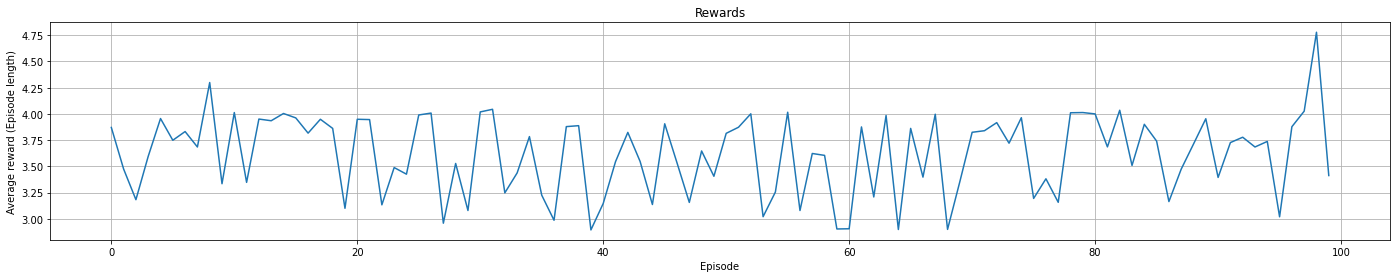

In [13]:
fig = plt.figure(figsize=(24, 4))
plt.title("Rewards")
plt.xlabel("Episode")
plt.ylabel("Average reward (Episode length)")
plt.plot(total_rewards)
plt.grid()
plt.show()

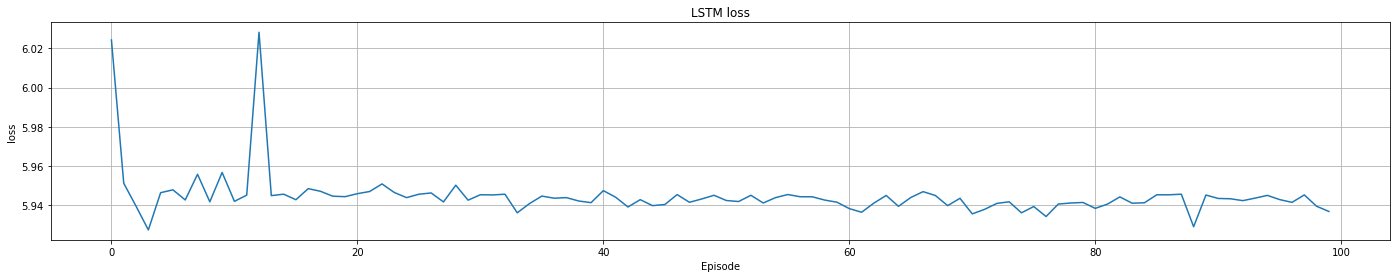

In [14]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_loss)), history_loss)
plt.title("LSTM loss")
plt.xlabel("Episode")
plt.ylabel("loss")
# plt.axhline(y=0, c="k")
plt.grid()
plt.show()

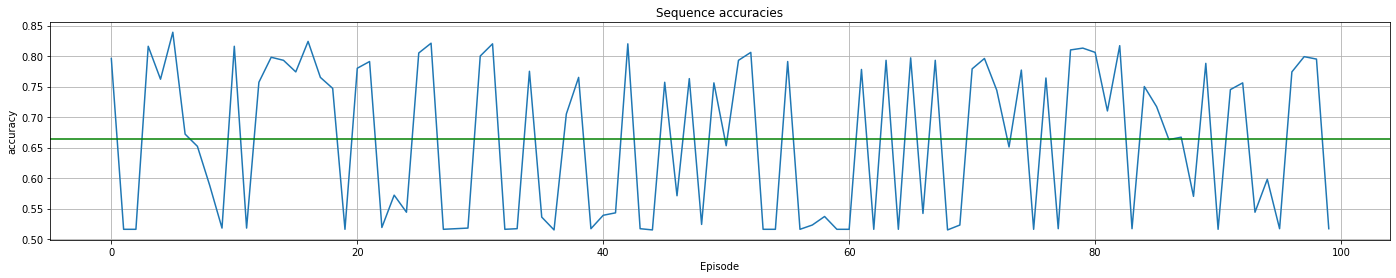

Best accuracy: 0.839
Average accuracy: 0.66326


In [15]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_accuracy)), history_accuracy)
plt.axhline(y=np.average(history_accuracy), c="g")
plt.title("Sequence accuracies")
plt.xlabel("Episode")
plt.ylabel("accuracy")
plt.grid()
plt.show()
print("Best accuracy:", max(history_accuracy))
print("Average accuracy:", np.average(history_accuracy))

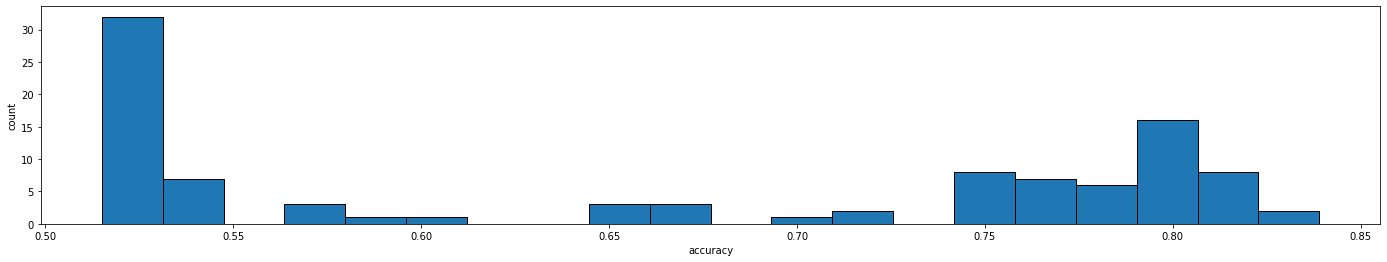

In [16]:
fig = plt.figure(figsize=(24, 4))
bins = int(len(history_accuracy)/5)
plt.hist(history_accuracy, bins=bins, edgecolor="k")
plt.xlabel("accuracy")
plt.ylabel("count")
plt.show()

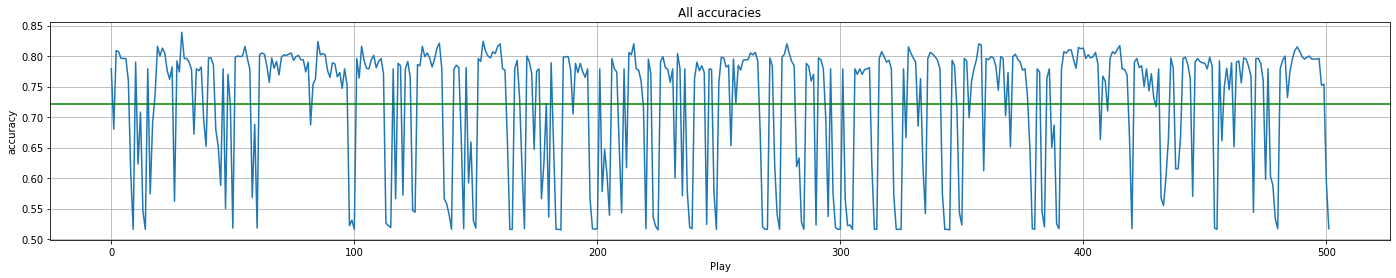

In [17]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_acc)), history_acc)
plt.axhline(y=np.average(history_acc), c="g")
plt.title("All accuracies")
plt.xlabel("Play")
plt.ylabel("accuracy")
plt.grid()
plt.show()